# WGAN-GP em radiografias panorâmicas
Adapatado [deste](https://github.com/eriklindernoren/PyTorch-GAN) repositório

In [14]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageFile

from configs import Configs
from data import RadiographAgeSet

In [15]:
os.makedirs("images", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

ImageFile.LOAD_TRUNCATED_IMAGES = True
configs = Configs(model="wgan-gp")

img_shape = (configs.channels, configs.img_size, configs.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(configs.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()


torch.Size([3, 224, 224])


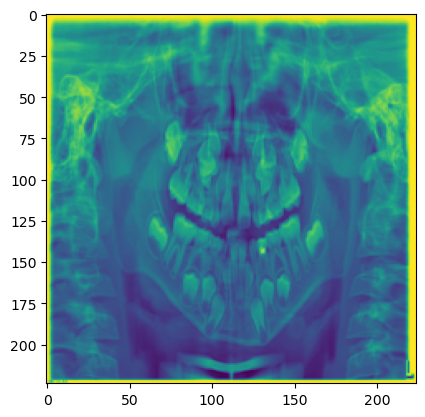

In [16]:
# Load radiographs
t = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((configs.img_size,configs.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(configs.mean, configs.stdv),
])

dataset = RadiographAgeSet(annotations_file=configs.csv,
                           img_dir=configs.root_dir+'/images/',
                           transform=t)

dataloader = DataLoader(dataset,
                        batch_size=configs.batch_size,
                        shuffle=configs.shuffle)

plt.imshow(dataset[0][0][0])
print(dataset[0][0].size())

In [17]:
# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=configs.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=configs.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [18]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = autograd.Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [19]:
# Training

batches_done = 0
for epoch in range(configs.n_epochs):

    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = autograd.Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = autograd.Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], configs.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z) #.detach()

        # print("Real images:", real_imgs.size())
        # print("Fake Images:", fake_imgs.size())

        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs)

        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)

        # Adversarial loss
        loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + configs.lambda_gp*gradient_penalty

        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic iterations
        if i % configs.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------            

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, configs.n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )

        if batches_done % configs.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
        batches_done += 1



[Epoch 0/200] [Batch 0/138] [D loss: 8.287612] [G loss: 0.352463]


KeyboardInterrupt: 

In [20]:
name = configs.checkpoint_save_file_name
torch.save(generator.state_dict(), './gen_' + name + '.pt')
torch.save(discriminator.state_dict(), './dis_' + name + '.pt')